# StatPhys-ML: Basic Usage Tutorial

This notebook demonstrates the basic usage of the `statphys-ml` package.

## Table of Contents
1. Package Import
2. Dataset
3. Model
   - 3.5 Automatic Order Parameter Calculation
4. Loss Function
5. Running Simulation
6. Visualization with Default Plotting Functions

## 1. Package Import

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Import statphys package
import statphys

# Display package information
statphys.info()

StatPhys-ML v0.1.0
Author: Yuma Ichikawa

Available modules:
  - dataset: Data generation (Gaussian, Sparse, Structured)
  - model: Learning models (Linear, Committee, MLP, Transformer)
  - loss: Loss functions (MSE, Ridge, LASSO, Hinge, Logistic)
  - theory: Theoretical calculations (Replica, Online ODEs)
  - simulation: Numerical experiments
  - vis: Visualization tools


In [2]:
# Fix random seed for reproducibility
statphys.fix_seed(42)

# Check available device
device = statphys.get_device()
print(f"Using device: {device}")

Using device: cpu


## 2. Dataset

Generate data in the Teacher-Student setting.

**Basic Parameters:**
- `d`: Input dimension
- `rho`: Norm of teacher weights (||w*||^2 / d)
- `eta`: Label noise variance

In [3]:
from statphys.dataset import GaussianDataset, GaussianClassificationDataset

# Create dataset for regression
d = 100  # Input dimension
rho = 1.0  # Teacher weight norm
eta = 0.1  # Noise variance

dataset = GaussianDataset(d=d, rho=rho, eta=eta)
print(f"Dataset created: d={d}, rho={rho}, eta={eta}")

Dataset created: d=100, rho=1.0, eta=0.1


In [4]:
# Generate data
alpha = 2.0  # Sample ratio (n/d)
n = int(alpha * d)  # Number of samples

X, y = dataset.generate_dataset(n_samples=n)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Samples: n={n}, alpha=n/d={alpha}")

X shape: torch.Size([200, 100])
y shape: torch.Size([200])
Samples: n=200, alpha=n/d=2.0


In [5]:
# Get teacher weights
teacher_w = dataset.get_teacher_params()["W0"]
print(f"Teacher weights shape: {teacher_w.shape}")
print(f"Teacher weights norm^2/d: {(teacher_w**2).sum().item() / d:.4f}")

Teacher weights shape: torch.Size([100, 1])
Teacher weights norm^2/d: 0.9668


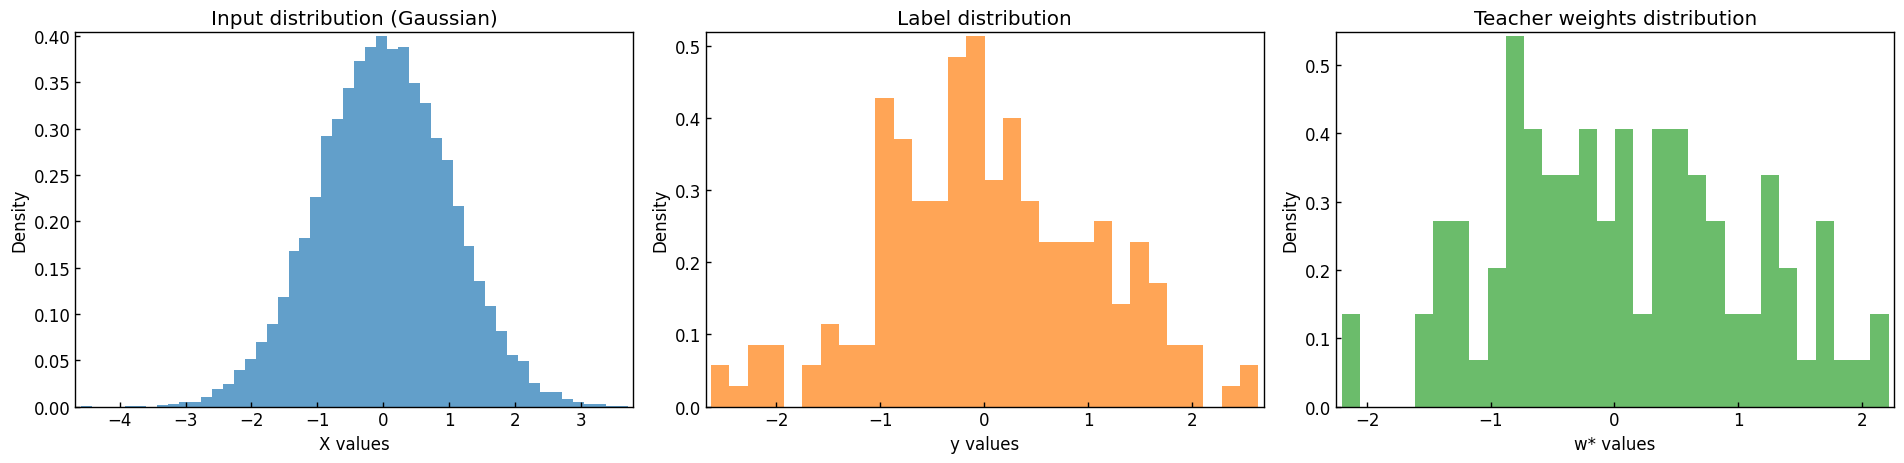

In [6]:
# Apply paper style for all plots
from statphys.vis import apply_paper_style, DEFAULT_FIGSIZE
apply_paper_style()

# Visualize data distributions
fig, axes = plt.subplots(1, 3, figsize=(DEFAULT_FIGSIZE[0] * 3, DEFAULT_FIGSIZE[1]))

# Input data histogram
axes[0].hist(X.numpy().flatten(), bins=50, density=True, alpha=0.7)
axes[0].set_xlabel("X values")
axes[0].set_ylabel("Density")
axes[0].set_title("Input distribution (Gaussian)")

# Output label histogram
axes[1].hist(y.numpy(), bins=30, density=True, alpha=0.7, color="tab:orange")
axes[1].set_xlabel("y values")
axes[1].set_ylabel("Density")
axes[1].set_title("Label distribution")

# Teacher weights histogram
axes[2].hist(teacher_w.numpy(), bins=30, density=True, alpha=0.7, color="tab:green")
axes[2].set_xlabel("w* values")
axes[2].set_ylabel("Density")
axes[2].set_title("Teacher weights distribution")

plt.tight_layout()
plt.show()

## 3. Model

Define learning models.

In [7]:
from statphys.model import LinearRegression, CommitteeMachine, TwoLayerNetwork

# Linear regression model
model = LinearRegression(d=d)
print(f"Model: {model.__class__.__name__}")
print(f"Parameters: {sum(p.numel() for p in model.parameters())}")

Model: LinearRegression
Parameters: 100


In [8]:
# Forward pass test
with torch.no_grad():
    y_pred = model(X)
print(f"Prediction shape: {y_pred.shape}")
print(f"Prediction mean: {y_pred.mean().item():.4f}")

Prediction shape: torch.Size([200])
Prediction mean: 0.0893


In [9]:
# Compute Order Parameters
# m: overlap with teacher weights, q: self-overlap
teacher_params = dataset.get_teacher_params()
order_params = model.compute_order_params(teacher_params)
print(f"Initial order parameters:")
print(f"  m (teacher overlap): {order_params['m']:.4f}")
print(f"  q (self overlap): {order_params['q']:.4f}")
print(f"  Eg (generalization error): {order_params['eg']:.4f}")

Initial order parameters:
  m (teacher overlap): -0.0578
  q (self overlap): 0.8922
  Eg (generalization error): 1.0039


## 3.5 Automatic Order Parameter Calculation

The `OrderParameterCalculator` class provides **automatic extraction** of ALL relevant order parameters:
- **Student-Teacher Overlaps (M)**: All overlaps between student and teacher parameters
- **Student Self-Overlaps (Q)**: Self-overlap matrix (important for committee machines)
- **Teacher Self-Overlaps (R)**: From dataset parameters
- **O(1) Scalars**: Bias terms, second-layer weights, etc.

This feature automatically detects model type (Linear, Committee, TwoLayer, etc.) and task type (Regression, Classification).

In [10]:
from statphys.utils.order_params import OrderParameterCalculator, auto_calc_order_params

# Method 1: Quick calculation with auto_calc_order_params
params_list = auto_calc_order_params(dataset, model)
print("Quick calculation (list format):")
print(f"  [m, q, eg] = {params_list}")

# Method 2: Dict format for named access
params_dict = auto_calc_order_params(dataset, model, return_format="dict")
print("\nDict format:")
for key, value in params_dict.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.6f}")

# Method 3: Full OrderParameters object with detailed information
calculator = OrderParameterCalculator(
    return_format="object",
    include_matrices=True,
    include_teacher_overlaps=True,
    verbose=True,
)
params_obj = calculator(dataset, model)
print("\nDetailed Summary:")
print(params_obj.summary())

Quick calculation (list format):
  [m, q, eg] = [-0.057818284034729, 0.8921550750732422, 1.05389582157135]

Dict format:
  M_w_W0: -0.057818
  M_avg: -0.057818
  Q_w_w: 0.892155
  Q_diag_avg: 0.892155
  R_W0_W0: 0.966770
  teacher_rho: 1.000000
  teacher_eta: 0.100000
  eg: 1.053896
Detected model type: linear
Detected task type: regression

Detailed Summary:
=== Order Parameters ===

[Student-Teacher Overlaps (M)]
  w_W0: -0.057818
  avg: -0.057818

[Student Self-Overlaps (Q)]
  w_w: 0.892155
  diag_avg: 0.892155

[Teacher Self-Overlaps (R)]
  W0_W0: 0.966770

[Scalars (O(1) quantities)]
  teacher_rho: 1.000000
  teacher_eta: 0.100000

[Generalization Error]: 1.053896


In [11]:
# Using auto_order_params in SimulationConfig
# The auto_order_params option controls how order parameters are computed:
# - True: Use OrderParameterCalculator (comprehensive, automatic detection)
# - False: Use default simple calculation (m, q, eg only)
#
# This feature is supported by BOTH ReplicaSimulation and OnlineSimulation.

from statphys.simulation import SimulationConfig, ReplicaSimulation, OnlineSimulation
from statphys.loss import RidgeLoss

# ============================================================
# DEMO 1: ReplicaSimulation + auto_order_params=False
# ============================================================
print("=" * 70)
print("DEMO 1: ReplicaSimulation + auto_order_params=False (Default)")
print("=" * 70)

config_replica_default = SimulationConfig.for_replica(
    alpha_range=(1.0, 2.0),
    alpha_steps=2,
    n_seeds=1,
    auto_order_params=False,
    reg_param=0.1,
    verbose=True,
    max_iter=100,
    patience=10,
)

sim_replica_default = ReplicaSimulation(config_replica_default)
results_replica_default = sim_replica_default.run(
    dataset=dataset,
    model_class=LinearRegression,
    loss_fn=RidgeLoss(0.1),
)

print("\nResults (simple m, q, eg):")
print(f"  alpha=1.0: {results_replica_default.experiment_results['order_params_mean'][0]}")
print(f"  alpha=2.0: {results_replica_default.experiment_results['order_params_mean'][1]}")

# ============================================================
# DEMO 2: ReplicaSimulation + auto_order_params=True
# ============================================================
print("\n")
print("=" * 70)
print("DEMO 2: ReplicaSimulation + auto_order_params=True")
print("=" * 70)

config_replica_auto = SimulationConfig.for_replica(
    alpha_range=(1.0, 2.0),
    alpha_steps=2,
    n_seeds=1,
    auto_order_params=True,
    reg_param=0.1,
    verbose=True,
    max_iter=100,
    patience=10,
)

sim_replica_auto = ReplicaSimulation(config_replica_auto)
results_replica_auto = sim_replica_auto.run(
    dataset=dataset,
    model_class=LinearRegression,
    loss_fn=RidgeLoss(0.1),
)

print("\nResults (auto-detected order params):")
print(f"  alpha=1.0: {results_replica_auto.experiment_results['order_params_mean'][0]}")
print(f"  alpha=2.0: {results_replica_auto.experiment_results['order_params_mean'][1]}")

# ============================================================
# DEMO 3: OnlineSimulation + auto_order_params=False
# ============================================================
print("\n")
print("=" * 70)
print("DEMO 3: OnlineSimulation + auto_order_params=False (Default)")
print("=" * 70)

config_online_default = SimulationConfig.for_online(
    t_max=1.0,
    t_steps=3,
    n_seeds=1,
    auto_order_params=False,
    lr=0.1,
    verbose=True,
)

sim_online_default = OnlineSimulation(config_online_default)
results_online_default = sim_online_default.run(
    dataset=dataset,
    model_class=LinearRegression,
    loss_fn=RidgeLoss(0.1),
)

print("\nResults (simple m, q, eg trajectories):")
for i, t in enumerate([0.0, 0.5, 1.0]):
    print(f"  t={t}: {results_online_default.experiment_results['trajectories_mean'][i]}")

# ============================================================
# DEMO 4: OnlineSimulation + auto_order_params=True
# ============================================================
print("\n")
print("=" * 70)
print("DEMO 4: OnlineSimulation + auto_order_params=True")
print("=" * 70)

config_online_auto = SimulationConfig.for_online(
    t_max=1.0,
    t_steps=3,
    n_seeds=1,
    auto_order_params=True,
    lr=0.1,
    verbose=True,
)

sim_online_auto = OnlineSimulation(config_online_auto)
results_online_auto = sim_online_auto.run(
    dataset=dataset,
    model_class=LinearRegression,
    loss_fn=RidgeLoss(0.1),
)

print("\nResults (auto-detected order param trajectories):")
for i, t in enumerate([0.0, 0.5, 1.0]):
    print(f"  t={t}: {results_online_auto.experiment_results['trajectories_mean'][i]}")


DEMO 1: ReplicaSimulation + auto_order_params=False (Default)
【TRIAL 1/1, SEED 100】



Results (simple m, q, eg):
  alpha=1.0: [0.0659048855304718, 0.21344628930091858, 0.5408182591199875]
  alpha=2.0: [0.1091487854719162, 0.10908684134483337, 0.4453946352005005]


DEMO 2: ReplicaSimulation + auto_order_params=True
【AUTO ORDER PARAMETER CALCULATION ENABLED】
  Model Type: linear
  Task Type:  regression

  Order Parameters to be computed:
    [0] m: Student-Teacher overlap (M = W^T @ W0 / d)
    [1] q: Student self-overlap (Q = W^T @ W / d)
    [2] eg: Generalization error (E_g)

  Additional computed quantities:
    - All Student-Teacher overlaps (M matrix)
    - All Student self-overlaps (Q matrix)
    - Teacher self-overlaps (R matrix)
    - O(1) scalars (bias, second-layer weights)

【TRIAL 1/1, SEED 100】

Results (auto-detected order params):
  alpha=1.0: [0.0659048843383789, 0.21344640731811523, 0.5908183193206787]
  alpha=2.0: [0.10914878845214844, 0.10908683776855468, 0.4953946304321289]


DEMO 3: OnlineSimulation + auto_order_params=False (Default)
【TRIAL 1/1, SE


Results (simple m, q, eg trajectories):
  t=0.0: [0.06996908783912659, 1.1192500591278076, 0.9896559417247772]
  t=0.5: [0.15827913582324982, 0.9720685482025146, 0.8277551382780075]
  t=1.0: [0.24411433935165405, 0.870496928691864, 0.691134124994278]


DEMO 4: OnlineSimulation + auto_order_params=True
【AUTO ORDER PARAMETER CALCULATION ENABLED】
  Model Type: linear
  Task Type:  regression

  Order Parameters to be computed:
    [0] m: Student-Teacher overlap (M = W^T @ W0 / d)
    [1] q: Student self-overlap (Q = W^T @ W / d)
    [2] eg: Generalization error (E_g)

  Additional computed quantities:
    - All Student-Teacher overlaps (M matrix)
    - All Student self-overlaps (Q matrix)
    - Teacher self-overlaps (R matrix)
    - O(1) scalars (bias, second-layer weights)

【TRIAL 1/1, SEED 100】

Results (auto-detected order param trajectories):
  t=0.0: [0.06996909141540528, 1.119250259399414, 1.0396560382843016]
  t=0.5: [0.1582791519165039, 0.9720687103271485, 0.8777552032470703]
  t

## 4. Loss Function

In [12]:
from statphys.loss import MSELoss, RidgeLoss, LassoLoss

# MSE loss
mse_loss = MSELoss()

# Ridge loss (with L2 regularization)
reg_param = 0.1
ridge_loss = RidgeLoss(reg_param=reg_param)

print(f"Available loss functions: MSE, Ridge (lambda={reg_param}), LASSO, etc.")

Available loss functions: MSE, Ridge (lambda=0.1), LASSO, etc.


In [13]:
# Loss computation example
with torch.no_grad():
    y_pred = model(X)
    
loss_mse = mse_loss(y_pred, y)
loss_ridge = ridge_loss(y_pred, y, model)

print(f"MSE Loss: {loss_mse.item():.4f}")
print(f"Ridge Loss: {loss_ridge.item():.4f}")

MSE Loss: 1.9090
Ridge Loss: 10.8306


## 5. Running Simulation

Run simulation for static analysis using the Replica method.

In [14]:
from statphys.simulation import SimulationConfig, ReplicaSimulation

# Simulation configuration
config = SimulationConfig.for_replica(
    alpha_range=(0.5, 5.0),  # Range of alpha
    alpha_steps=10,           # Number of alpha values
    n_seeds=3,                # Number of seeds
    lr=0.1,                   # Learning rate
    max_iter=5000,            # Maximum iterations
    tol=1e-5,                 # Convergence threshold
    patience=30,              # Early stopping patience
    reg_param=reg_param,      # Regularization parameter
    verbose=True,             # Show progress
)

print(f"Alpha values: {config.alpha_values}")

Alpha values: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [15]:
# Recreate dataset for simulation (larger dimension for better accuracy)
d_sim = 200
dataset_sim = GaussianDataset(d=d_sim, rho=rho, eta=eta)

# Run simulation
sim = ReplicaSimulation(config)
results = sim.run(
    dataset=dataset_sim,
    model_class=LinearRegression,
    loss_fn=ridge_loss,
)

print("\nSimulation completed!")

【TRIAL 1/3, SEED 100】
  α=0.50: Converged at iteration 99


  α=1.00: Converged at iteration 83


  α=1.50: Converged at iteration 87
  α=2.00: Converged at iteration 85
  α=2.50: Converged at iteration 82


  α=3.00: Converged at iteration 70
  α=3.50: Converged at iteration 74
  α=4.00: Converged at iteration 79


  α=4.50: Converged at iteration 77
  α=5.00: Converged at iteration 73
【TRIAL 2/3, SEED 101】
  α=0.50: Converged at iteration 99


  α=1.00: Converged at iteration 92
  α=1.50: Converged at iteration 88
  α=2.00: Converged at iteration 79


  α=2.50: Converged at iteration 80
  α=3.00: Converged at iteration 77


  α=3.50: Converged at iteration 78
  α=4.00: Converged at iteration 77


  α=4.50: Converged at iteration 74
  α=5.00: Converged at iteration 74
【TRIAL 3/3, SEED 102】
  α=0.50: Converged at iteration 95


  α=1.00: Converged at iteration 84
  α=1.50: Converged at iteration 86


  α=2.00: Converged at iteration 83
  α=2.50: Converged at iteration 76
  α=3.00: Converged at iteration 78


  α=3.50: Converged at iteration 77
  α=4.00: Converged at iteration 79


  α=4.50: Converged at iteration 76
  α=5.00: Converged at iteration 75

Simulation completed!


## 6. Visualization with Default Plotting Functions

Use the built-in publication-quality plotting functions.

In [16]:
from statphys.vis import (
    plot_generalization_error_alpha,
    plot_order_params_alpha,
    plot_from_replica_results,
)

# Extract results
alpha_values = np.array(results.experiment_results["alpha_values"])
op_mean = np.array(results.experiment_results["order_params_mean"])
op_std = np.array(results.experiment_results["order_params_std"])

print(f"Alpha values: {alpha_values}")
print(f"Order params shape: {op_mean.shape}")

Alpha values: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Order params shape: (10, 3)


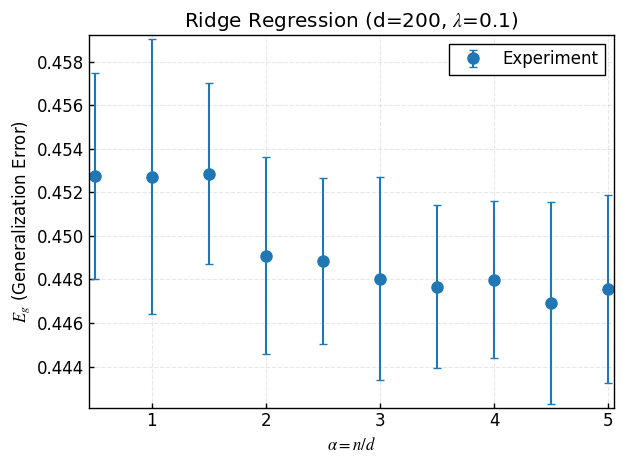

In [17]:
# Plot generalization error only
fig, ax = plot_generalization_error_alpha(
    alpha_values=alpha_values,
    eg_mean=op_mean[:, 2],
    eg_std=op_std[:, 2],
    title=f"Ridge Regression (d={d_sim}, $\\lambda$={reg_param})",
)

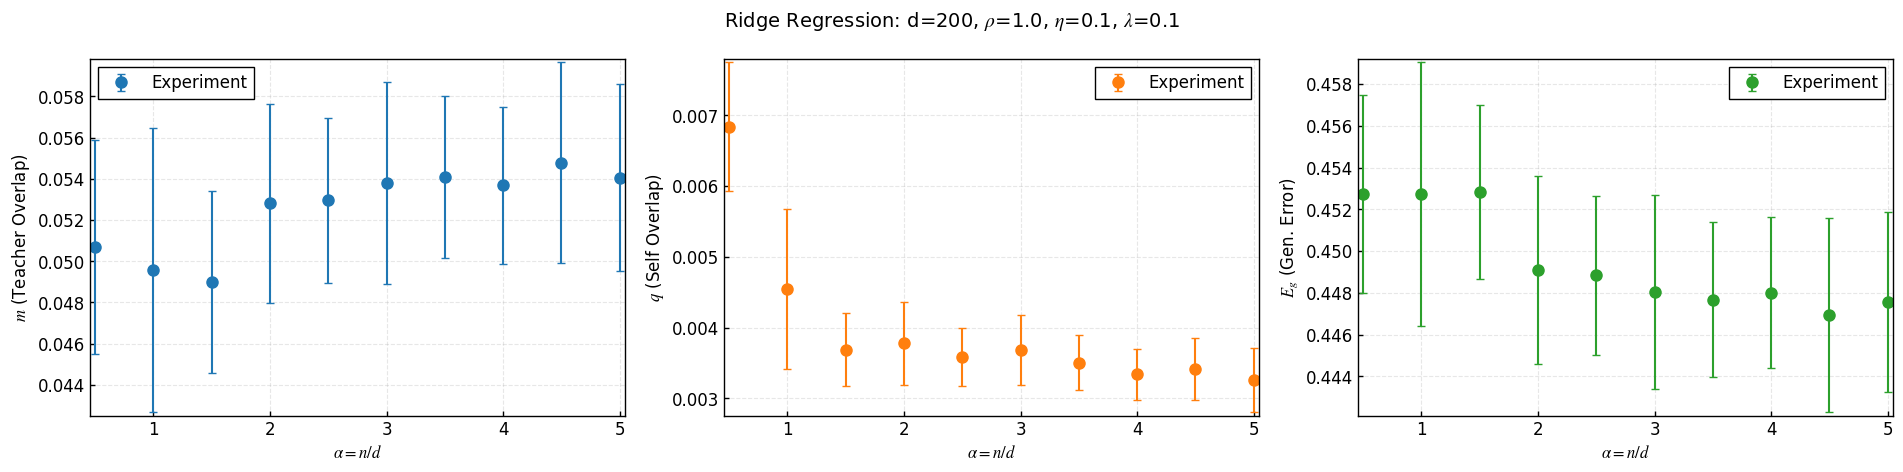

In [18]:
# Plot all order parameters (m, q, Eg) in one figure
fig, axes = plot_order_params_alpha(
    alpha_values=alpha_values,
    m_mean=op_mean[:, 0],
    q_mean=op_mean[:, 1],
    eg_mean=op_mean[:, 2],
    m_std=op_std[:, 0],
    q_std=op_std[:, 1],
    eg_std=op_std[:, 2],
    title=f"Ridge Regression: d={d_sim}, $\\rho$={rho}, $\\eta$={eta}, $\\lambda$={reg_param}",
)

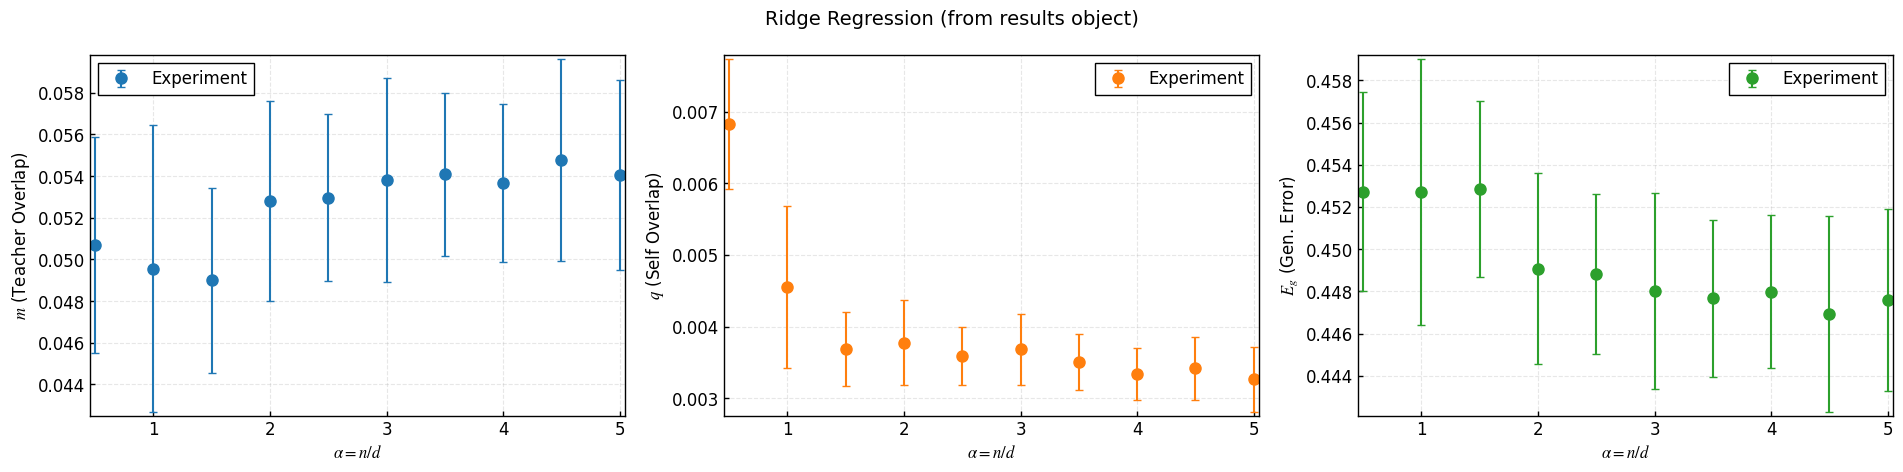

In [19]:
# Alternatively, use the convenience function that takes results directly
fig, axes = plot_from_replica_results(
    results,
    plot_type="all",  # "eg" for generalization error only, "all" for all order params
    title="Ridge Regression (from results object)",
)

## Summary

This notebook demonstrated the basic usage of the `statphys-ml` package:

1. **Dataset**: Generate Teacher-Student data using `GaussianDataset`
2. **Model**: Define learning models with `LinearRegression`
3. **Order Parameters**: Automatically compute all order parameters using `OrderParameterCalculator` or `auto_calc_order_params`:
   - Student-Teacher overlaps (M)
   - Student self-overlaps (Q)
   - Teacher self-overlaps (R)
   - Generalization error (E_g)
4. **Loss**: Use loss functions with L2 regularization via `RidgeLoss`
5. **Simulation**: Compute alpha-dependence using `ReplicaSimulation`
6. **Visualization**: Use built-in functions for publication-quality plots:
   - `plot_generalization_error_alpha()`: Single plot for $E_g$ vs $\alpha$
   - `plot_order_params_alpha()`: Combined plot for all order parameters
   - `plot_from_replica_results()`: Convenience function for quick plotting

For more detailed examples, see other scripts in the `examples/` directory.